<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#A/B-Analysis" data-toc-modified-id="A/B-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A/B Analysis</a></span></li></ul></div>

In [1]:
# import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
plt.style.use('seaborn')
%matplotlib inline

In [2]:
# import dataset 
df = pd.read_csv('referral.csv',parse_dates= ['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df.head()

,user_id,date,country,money_spent,is_referral,device_id,day_of_week
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG,5
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX,5
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG,5
3,7,2015-10-03,UK,73,0,PRGXJZAJKMXRH,5
4,7,2015-10-03,MX,35,0,PRGXJZAJKMXRH,5


In [3]:
#basic data information 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97341 entries, 0 to 97340
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      97341 non-null  int64         
 1   date         97341 non-null  datetime64[ns]
 2   country      97341 non-null  object        
 3   money_spent  97341 non-null  int64         
 4   is_referral  97341 non-null  int64         
 5   device_id    97341 non-null  object        
 6   day_of_week  97341 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 5.2+ MB


In [4]:
# check duplicate 
def return_unique_value(col):
    print(col,'have',len(df[col].unique()),'unique values')

In [5]:
# check duplicate
cols = ['user_id','country','device_id']
for col in cols:
    return_unique_value(col)

user_id have 18809 unique values
country have 9 unique values
device_id have 17887 unique values


# Goal
---
- Can you estimate the impact the program had on the site?
- Based on the data, what would you suggest to do as a next step?
- The referral program wasn't really tested in a rigorous way. It simply started on a given day for all users and you are drawing conclusions by looking at the data before and after the test started. What kinds of risks this approach presents? Can you think of a better way to test the referral program and measure its impact?

# EDA

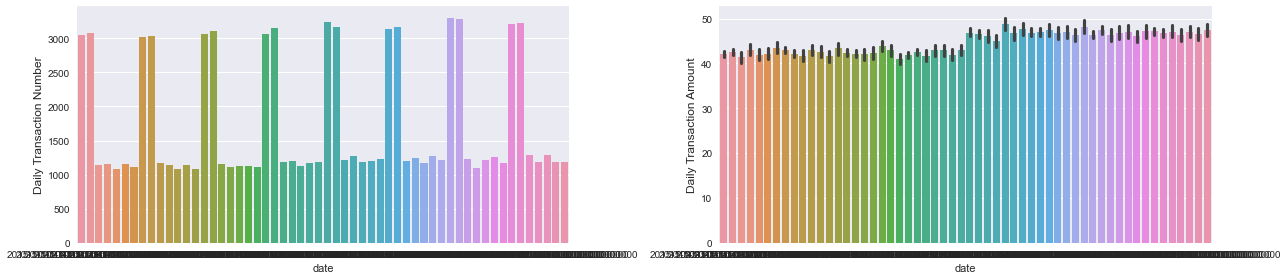

In [6]:
# Daily money spent visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
sns.countplot(data=df, x='date',ax = ax[0])
ax[0].set_ylabel('Daily Transaction Number', fontsize=12)

sns.barplot(data=df, x='date', y='money_spent')
ax[1].set_ylabel('Daily Transaction Amount', fontsize=12)
plt.tight_layout()
plt.show()

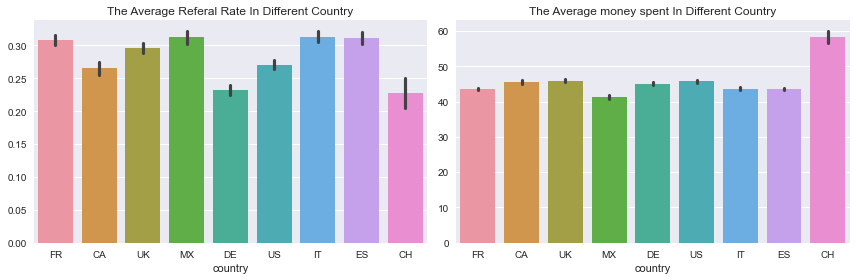

In [7]:
# country in Refer rate and money spent
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sns.barplot(data=df, x='country', y='is_referral',ax = ax[0])
ax[0].set_title('The Average Referal Rate In Different Country')
ax[0].set_ylabel('')

sns.barplot(data=df, x='country', y='money_spent',ax = ax[1])
ax[1].set_title('The Average money spent In Different Country')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

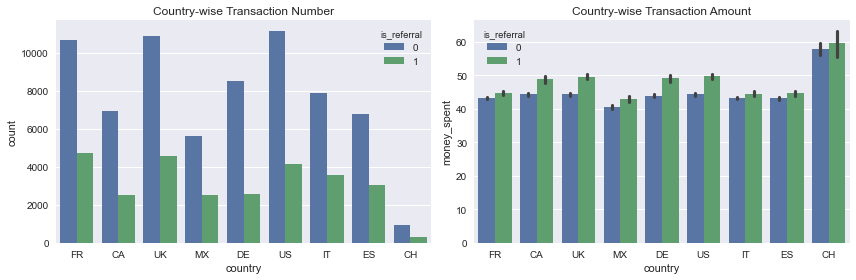

In [8]:
# daily money spent visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.countplot(x='country', hue='is_referral', data=df, ax=ax[0])
ax[0].set_title('Country-wise Transaction Number')

sns.barplot(x='country', y='money_spent', hue='is_referral', data=df, ax=ax[1])
ax[1].set_title('Country-wise Transaction Amount', fontsize=12)
plt.tight_layout()
plt.show()

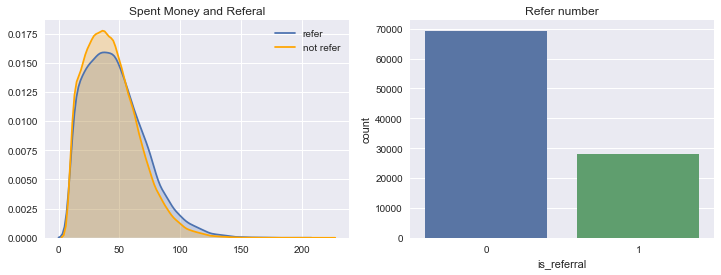

In [9]:
# spent money in refer
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sns.kdeplot(data=df[df['is_referral'] ==1]['money_spent'],shade = True,label = 'refer',ax = ax[0])
sns.kdeplot(data=df[df['is_referral'] ==0]['money_spent'],shade = True,label = 'not refer',color = 'orange',ax = ax[0])
ax[0].set_title('Spent Money and Referal')

sns.countplot(df['is_referral'],ax = ax[1])
ax[1].set_title('Refer number')

plt.show()

In [31]:
def basic_stat(df):
    """ function to calculate statistics """
    money_spent = df['money_spent'].sum()
    unique_user = len(df['user_id'].unique())
    
    return pd.Series([money_spent, unique_user], 
                     index=['money_spent', 'unique_user'])

In [32]:
print('start date:',df[df['is_referral']==1]['date'].min())
print('end date:',df[df['is_referral']==1]['date'].max())

start date: 2015-10-31 00:00:00
end date: 2015-11-27 00:00:00


最早开始refer的日子是2015-10-31

# A/B Analysis

In [33]:
start_date = pd.to_datetime('2015-10-31')
def daily_stat(data):
    grouped = data.groupby('date').apply(basic_stat).reset_index()
    ref = grouped[grouped['date'] < start_date]
    new = grouped[grouped['date'] >= start_date]
    
    names = ['money_spent', 'unique_user']
    vals = []
    for name in names:
        a = ref[name].values
        b = new[name].values
        # p-value should be one-side test
        p_val = ttest_ind(a, b, equal_var=False)[1] / 2
        vals.append(p_val)
        
    return pd.Series(vals, index=names)

In [34]:
df.groupby('country').apply(daily_stat).reset_index()

,country,money_spent,unique_user
0,CA,0.351704,0.268256
1,CH,0.006941,0.003142
2,DE,0.081459,0.015665
3,ES,0.037522,0.057954
4,FR,0.031843,0.041124
5,IT,0.025730,0.043911
6,MX,0.009670,0.026203
7,UK,0.048490,0.204398
8,US,0.248874,0.368860


从图和表格中可以看出：
- CH 和 DE 是有显著下降的。
- MX，IT，FR和ES是有显著增加的
- 剩余其他国家没有显著变化

In [15]:
df.groupby('day_of_week').apply(daily_stat).reset_index()

,day_of_week,no_purchase,money_spent,unique_user
0,0,0.012484,0.000368,0.000665
1,1,0.156965,0.007701,0.008802
2,2,0.009713,0.000301,0.001270
3,3,0.016584,0.000675,0.002578
4,4,0.016875,0.000595,0.000683
5,5,0.006828,0.000107,0.000125
6,6,0.011717,0.000133,0.000012
